<a href="https://colab.research.google.com/github/sysopjp/StableDiffusionColaboratory_NoForbiddenStrings/blob/main/Stable_Diffusion_with_%F0%9F%A7%A8_diffusers_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Aug 24 04:44:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

↑　GPUが動く事確認してね.     
もし動いてない場合は →の方からランタイムのタイプをGPUにしてね

In [ ]:
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()


# Hugging face でアカウント作って 利用規約にOKします
- https://huggingface.co/CompVis/stable-diffusion
- https://huggingface.co/CompVis/stable-diffusion-v-1-4-original

アカウント作ってから ↑のURLにアクセスすると利用規約が出るんだよ、へーそういうもんなのね感。


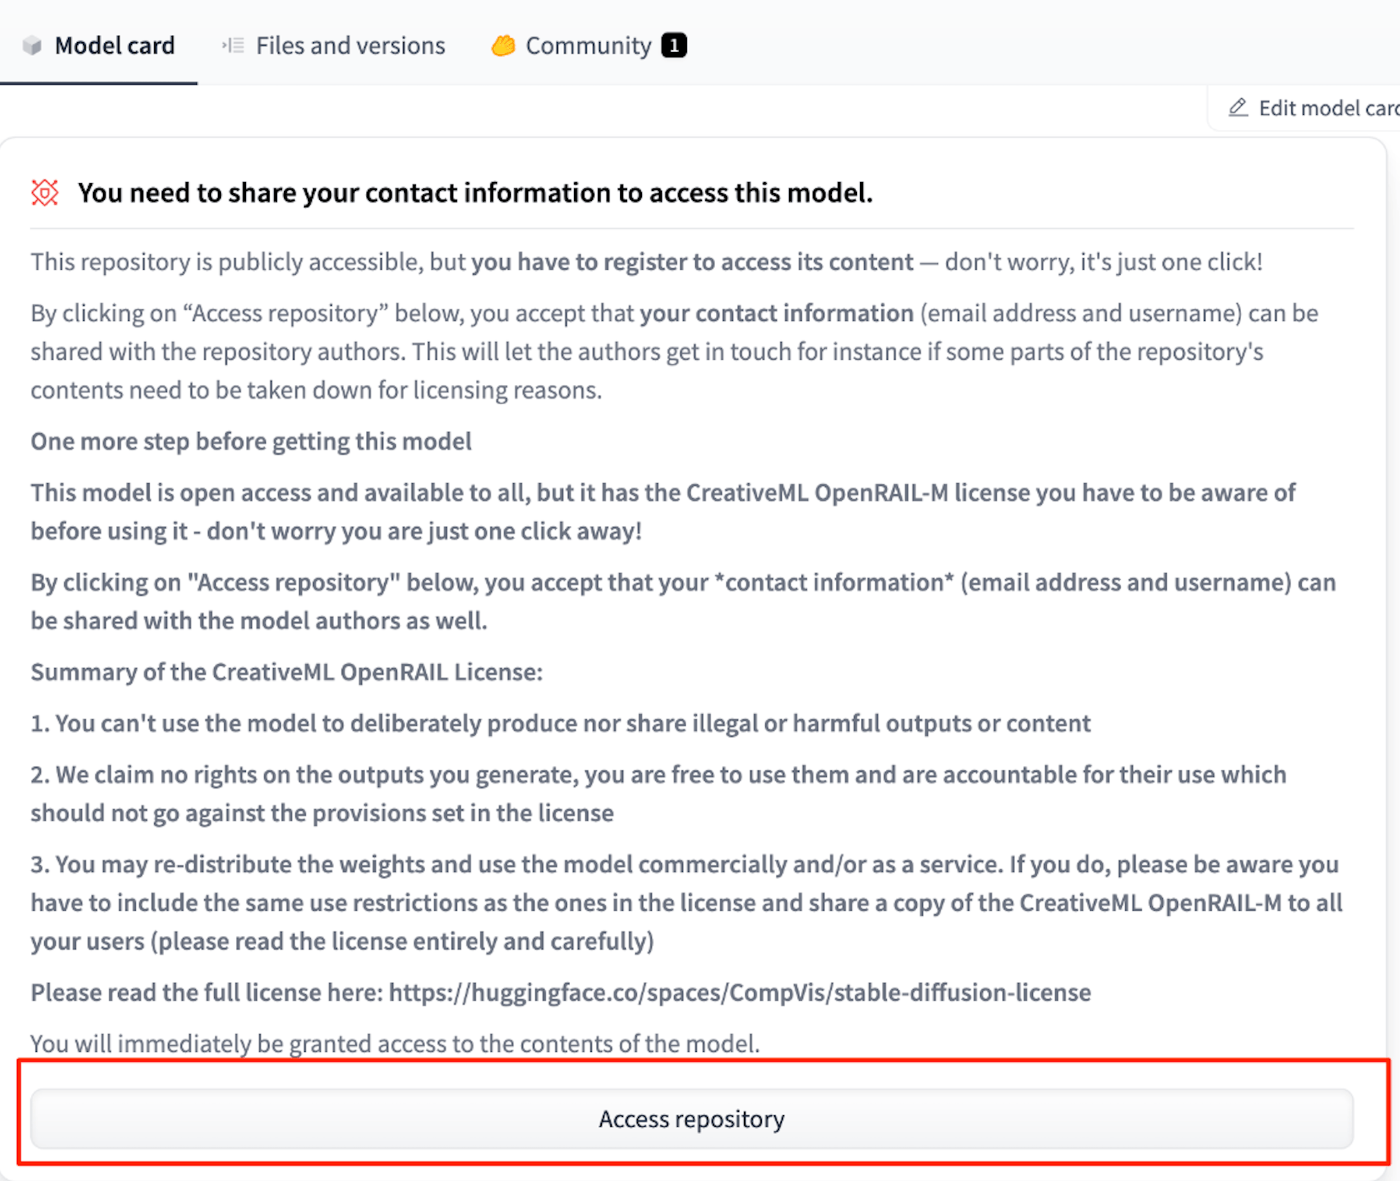

# API　token をコピー
`https://huggingface.co/settings/tokens`
権限的は read だけでOK


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

↑　実行すると赤い文字でるけど　　  
`Login successful　`

って一番上に出てれば残りは気にしないで良い

In [ ]:
# このセルは一回だけ実行で良い、色々DLしてきます
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True)  

In [ ]:
# このセルも一回だけ実行で良い

pipe = pipe.to("cuda")

from PIL import Image
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)

from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

from torch import autocast

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device) 


In [ ]:
# 実行関数
from tqdm.auto import tqdm

def run(prompt,generator,height,width,num_inference_steps,guidance_scale,batch_size):
  text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
  )
  latents = latents.to(torch_device)
  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.sigmas[0]


  with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

  # scale and decode the image latents with vae
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    image = vae.decode(latents)

  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")

  pil_images = [Image.fromarray(image) for image in images]
  return pil_images[0]


ここから下は好き勝手いじって遊ぶためのパラメーター

In [ ]:
num_inference_steps = 100            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
batch_size = 1


In [ ]:
#入力文字 ここに好きな禁則文字をいれてください
prompt = ["🍆"]

# 画像のサイズ
height = 256                        # default height of Stable Diffusion
width = 256                         # default width of Stable Diffusion

# SEED値、ここをかえると 同じ入力文字でも別の画像がでます
generator = torch.manual_seed(1)   


image = run(prompt,generator,height,width,num_inference_steps,guidance_scale,batch_size)
image

もっと詳しく知りたい人は
https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb#scrollTo=zHkHsdtnry57
こっちのちゃんとしたcolabを見るんだ！！！！
